In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score, precision_recall_curve,
                             average_precision_score)
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
with open('churn_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

with open('feature_names.pkl', 'rb') as f:
    feature_info = pickle.load(f)
    all_features = feature_info['all_features']
    numerical_features = feature_info['numerical_features']
    categorical_features = feature_info['categorical_features']

print("Loaded!")

Loaded!


In [3]:
df = pd.read_csv('processed_churn_data.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

X_encoded = X.copy()
for col in categorical_features:
    X_encoded[col] = label_encoders[col].transform(X[col].astype(str))

y_encoded = (y == 'Yes').astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Test set: {X_test.shape[0]} samples")


Test set: 1409 samples


In [4]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"TN: {tn}  FP: {fp}")
print(f"FN: {fn}  TP: {tp}")

TN: 804  FP: 231
FN: 95  TP: 279


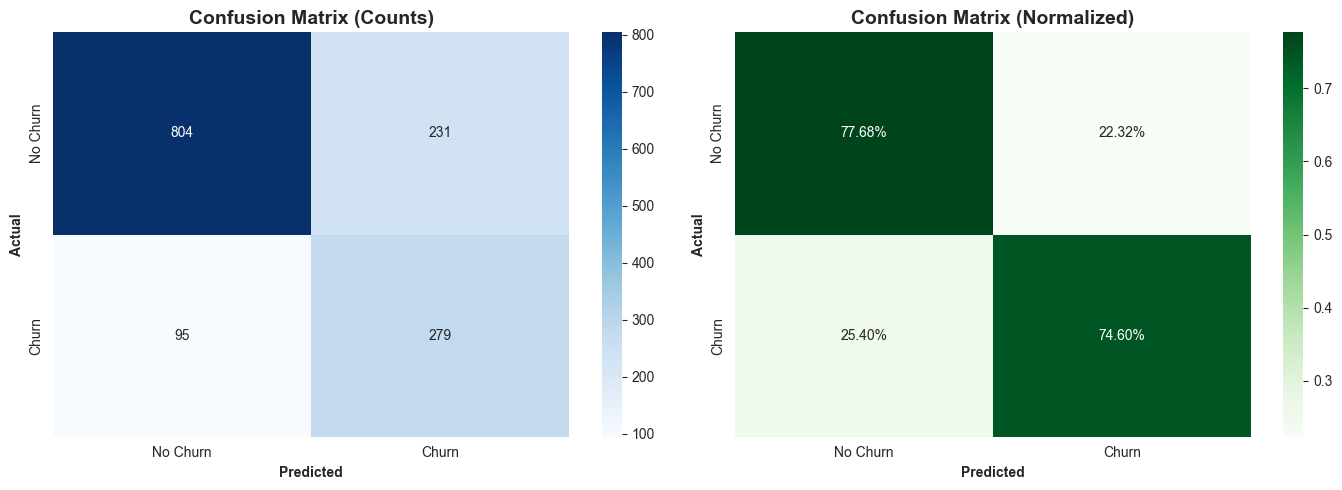

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontweight='bold')
axes[0].set_xlabel('Predicted', fontweight='bold')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontweight='bold')
axes[1].set_xlabel('Predicted', fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
print(classification_report(y_test, y_pred, 
                           target_names=['No Churn', 'Churn'],
                           digits=4))

              precision    recall  f1-score   support

    No Churn     0.8943    0.7768    0.8314      1035
       Churn     0.5471    0.7460    0.6312       374

    accuracy                         0.7686      1409
   macro avg     0.7207    0.7614    0.7313      1409
weighted avg     0.8021    0.7686    0.7783      1409



ROC-AUC: 0.8418


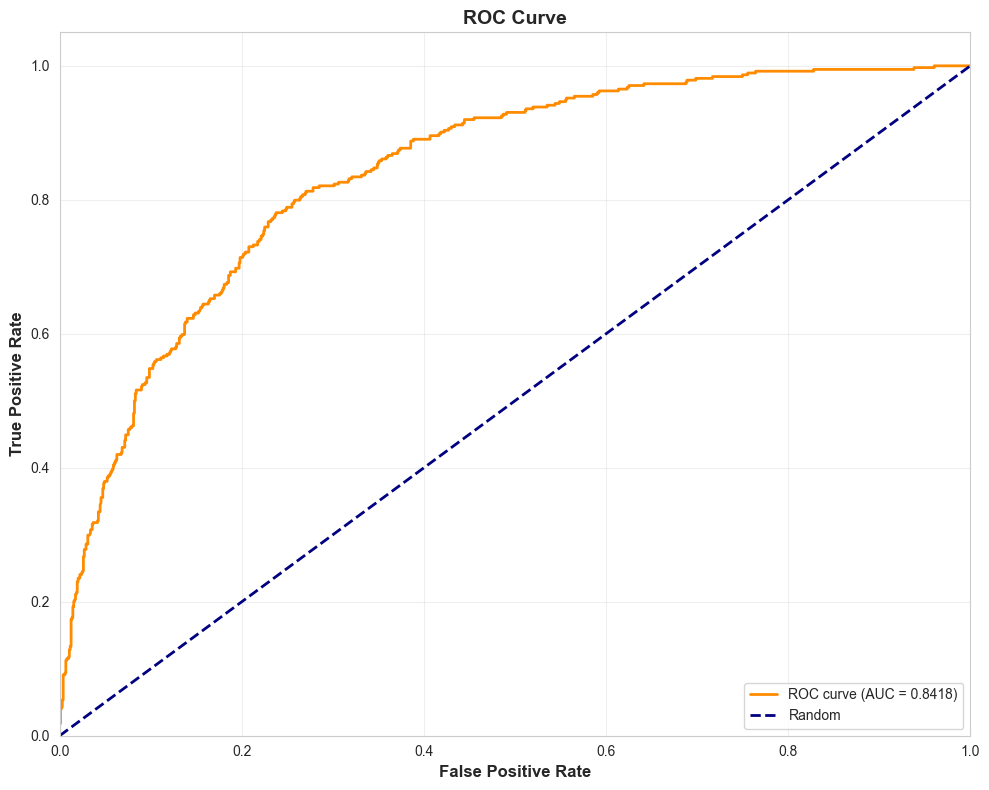

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Average Precision: 0.6583


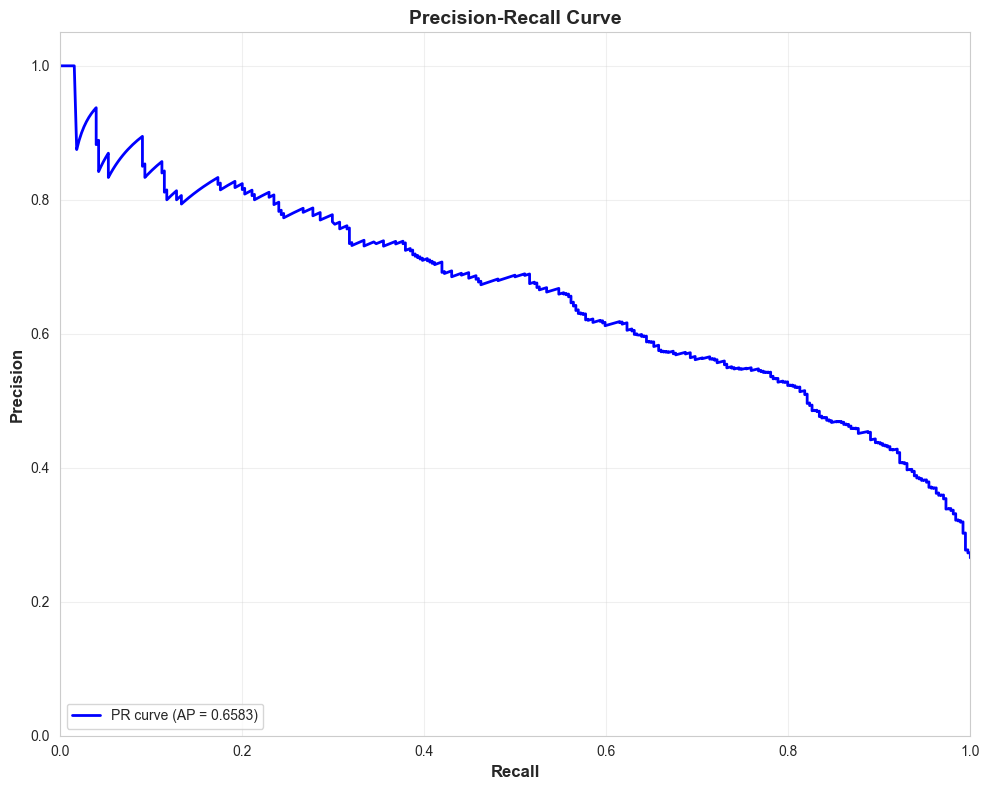

In [8]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Average Precision: {avg_precision:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [9]:
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    metrics_by_threshold.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

optimal_idx = metrics_df['F1-Score'].idxmax()
optimal_threshold = metrics_df.loc[optimal_idx, 'Threshold']
optimal_f1 = metrics_df.loc[optimal_idx, 'F1-Score']

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"F1-Score: {optimal_f1:.4f}")

Optimal Threshold: 0.45
F1-Score: 0.6358


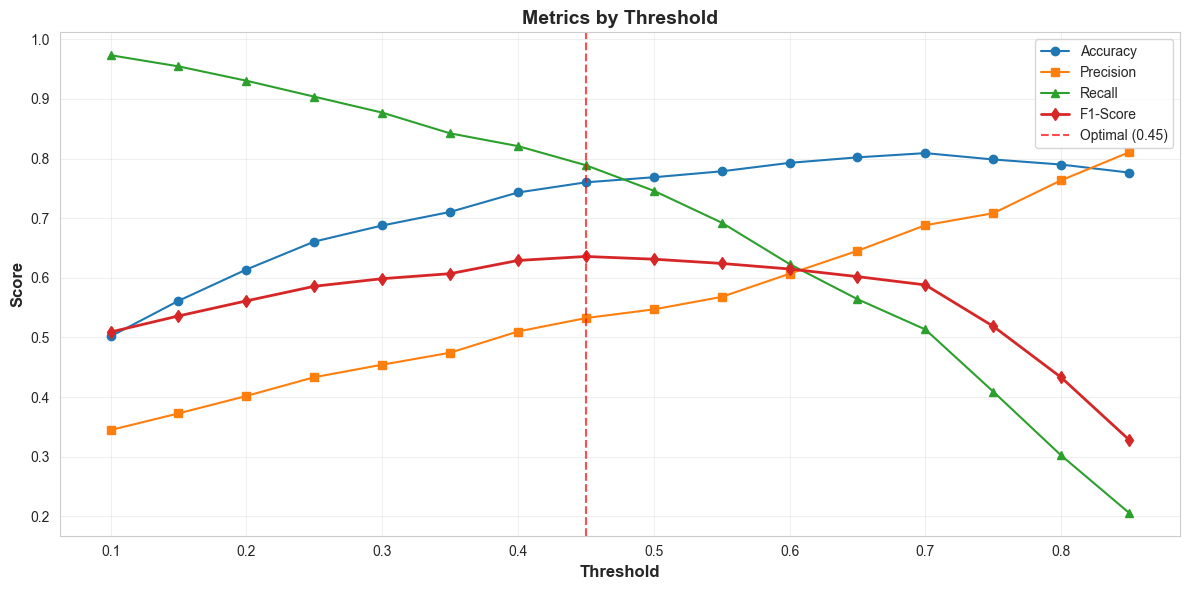

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall', marker='^')
plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], label='F1-Score', marker='d', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.2f})')
plt.xlabel('Threshold', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Metrics by Threshold', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))


         Feature  Importance
        Contract    0.193468
          tenure    0.146535
    TotalCharges    0.116909
  MonthlyCharges    0.114132
  OnlineSecurity    0.094990
     TechSupport    0.083287
 InternetService    0.048213
   PaymentMethod    0.040614
    OnlineBackup    0.029842
PaperlessBilling    0.020513
DeviceProtection    0.017361
   MultipleLines    0.014535
      Dependents    0.014160
     StreamingTV    0.013769
          gender    0.013597


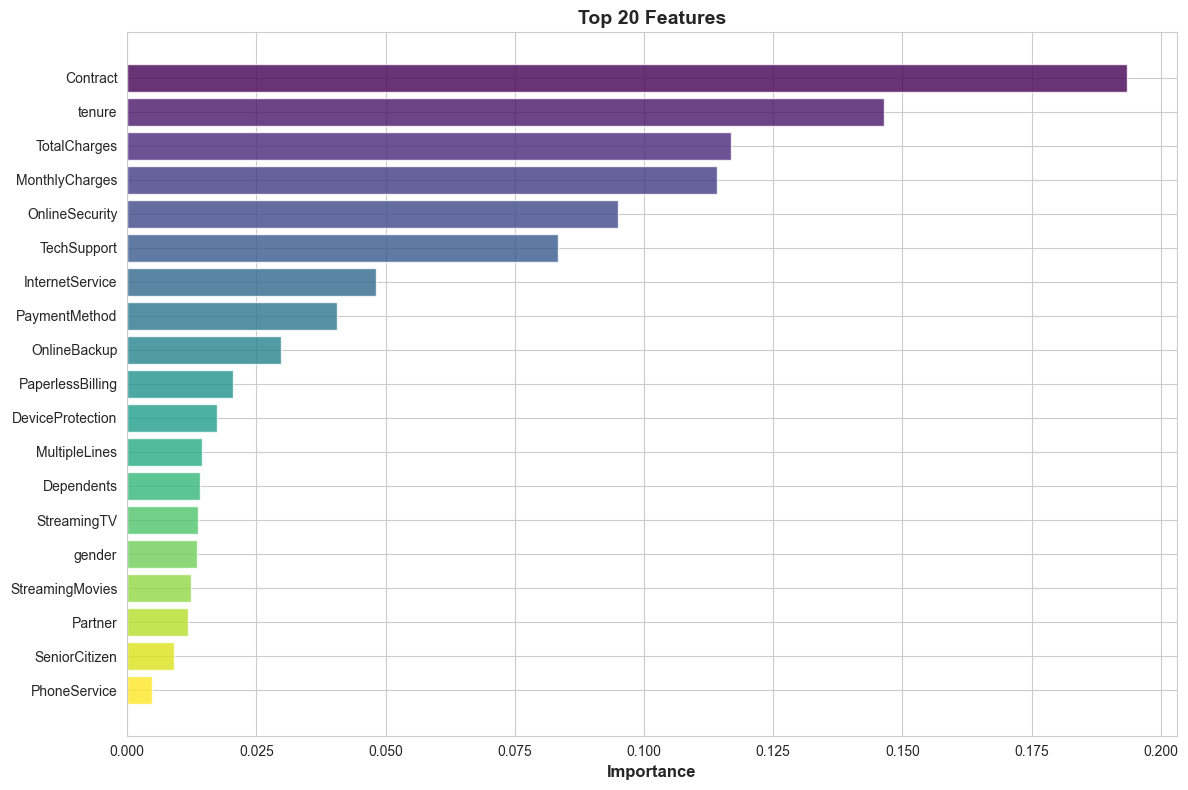

In [13]:
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)

colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

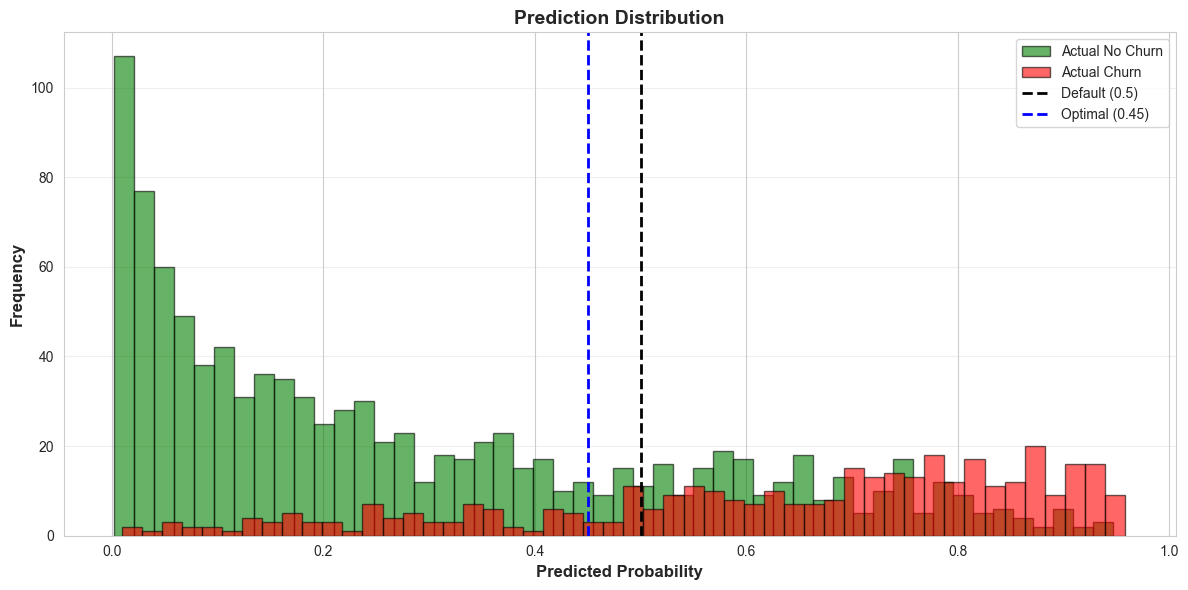

In [14]:
plt.figure(figsize=(12, 6))

plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label='Actual No Churn', color='green', edgecolor='black')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label='Actual Churn', color='red', edgecolor='black')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Default (0.5)')
plt.axvline(x=optimal_threshold, color='blue', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.2f})')

plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Prediction Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [16]:
total_customers = len(y_test)
actual_churners = y_test.sum()

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
tp_optimal = ((y_test == 1) & (y_pred_optimal == 1)).sum()
fp_optimal = ((y_test == 0) & (y_pred_optimal == 1)).sum()
fn_optimal = ((y_test == 1) & (y_pred_optimal == 0)).sum()

print(f"Total customers: {total_customers:,}")
print(f"Actual churners: {actual_churners:,} ({actual_churners/total_customers*100:.1f}%)")
print(f"Predicted churners: {y_pred_optimal.sum():,}")
print(f"\nCorrectly identified: {tp_optimal:,} ({tp_optimal/actual_churners*100:.1f}%)")
print(f"Missed: {fn_optimal:,} ({fn_optimal/actual_churners*100:.1f}%)")

Total customers: 1,409
Actual churners: 374 (26.5%)
Predicted churners: 554

Correctly identified: 295 (78.9%)
Missed: 79 (21.1%)


In [17]:
evaluation_results = {
    'roc_auc': roc_auc,
    'average_precision': avg_precision,
    'optimal_threshold': optimal_threshold,
    'confusion_matrix': cm.tolist(),
    'feature_importance': feature_importance.to_dict('records')
}

import json
with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)


In [18]:
evaluation_results

{'roc_auc': np.float64(0.8417525640032034),
 'average_precision': np.float64(0.6583045410907044),
 'optimal_threshold': np.float64(0.4500000000000001),
 'confusion_matrix': [[804, 231], [95, 279]],
 'feature_importance': [{'Feature': 'Contract',
   'Importance': 0.19346824745029859},
  {'Feature': 'tenure', 'Importance': 0.14653476249053743},
  {'Feature': 'TotalCharges', 'Importance': 0.11690936276848536},
  {'Feature': 'MonthlyCharges', 'Importance': 0.11413228606653564},
  {'Feature': 'OnlineSecurity', 'Importance': 0.0949898271811061},
  {'Feature': 'TechSupport', 'Importance': 0.08328748441421437},
  {'Feature': 'InternetService', 'Importance': 0.048212773969791956},
  {'Feature': 'PaymentMethod', 'Importance': 0.04061366063269663},
  {'Feature': 'OnlineBackup', 'Importance': 0.029842472012517},
  {'Feature': 'PaperlessBilling', 'Importance': 0.020512818526297164},
  {'Feature': 'DeviceProtection', 'Importance': 0.01736055703768693},
  {'Feature': 'MultipleLines', 'Importance': 0.